In [29]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_set = torchvision.datasets.ImageFolder('dataset/test',transform=trans)
test_loader = DataLoader(test_set)

model = torch.load('best_model.pt')
binary_model = torch.load('best_model_binary.pt')

model.eval()
binary_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
num_correct = 0
all_result = []

for x, y in tqdm(test_loader):
    x = x.to(device)
    y = y.to(device)
    
    output = model(x)
    binary_output = binary_model(x)
    
    is_trash = torch.argmax(binary_model(x), 1)
    prediction = torch.argmax(output, 1)
    
    if is_trash[0] == 1:
        # print(torch.max(torch.softmax(binary_output, 1)))
        # print(torch.max(torch.softmax(output, 1)), test_set.classes[prediction[0]], test_set.classes[y[0]])
        prediction[0] = 5
    
    if prediction == y:
        num_correct += 1
    
    all_result.append([y.cpu().detach().numpy()[0], prediction.cpu().detach().numpy()[0]])

accuracy = num_correct / len(test_loader)


100%|██████████| 431/431 [00:04<00:00, 86.44it/s]


Overall Accuracy: 0.9095127610208816
--------------------------------
cardboard Accuracy: 0.9142857142857143
glass Accuracy: 0.926829268292683
metal Accuracy: 0.9411764705882353
paper Accuracy: 0.8888888888888888
plastic Accuracy: 0.8918918918918919
trash Accuracy: 0.896551724137931


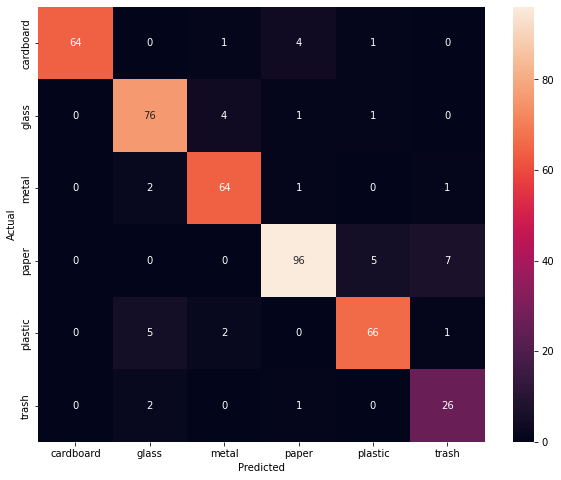

In [32]:
num_classes = len(test_set.classes)
cmt = np.zeros((num_classes, num_classes), np.int64)

for actual, predicted in all_result:
    cmt[actual, predicted] += 1

plt.figure(figsize=(10,8))
sns.heatmap(cmt, xticklabels=test_set.classes, yticklabels=test_set.classes, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print('Overall Accuracy:', accuracy)
print('--------------------------------')
for i in range(num_classes):
    per_class_acc = cmt[i, i] / cmt[i].sum()
    print(f"{test_set.classes[i]} Accuracy:", per_class_acc)
